<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#from pypardiso import spsolve

#Some plot settings
%run plot_functions/plot_settings.py

# Quick tests on nodal fluxes

## Divergence-free flow

Consider a linear concentration gradient of $\nabla c = 1$ on $x \in [0,1]$ for $v = 1$ and $D = 1$. We calculate nodal contributions based on the following terms (no units for the moment):

\begin{align}
    f_1 &= \int \limits_0^1 \nabla N^\text{T} v c \text{d}x
    \\
    f_2 &= \int \limits_0^1 N^\text{T} v \nabla c \text{d}x
    \\
    f_3 &= -\int \limits_0^1 \nabla N^\text{T} v \nabla c \text{d}x
\end{align}

$f_1$ is a treatment used for advection in models with total flux boundary conditions, $f_2$ is motivated by the implementation of advection with substituted mass balance (resulting in models with diffusive flux boundary conditions), $f_3$ for diffusion.

## Finite elements in 1D

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [3]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

In [4]:
#N
def shape_function(element_order,xi):
    if (element_order == 1):
            return np.array([1])
    elif (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
    elif (element_order == 4): #-1, -1/3, 1/3, 1
            return np.array([9/16*(1-xi)*(xi**2 - 1/9),
                            27/16*(xi**2-1)*(xi-1/3),
                            27/16*(1-xi**2)*(xi+1/3),
                            9/16*(xi+1)*(xi**2-1/9)])
        
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 1):
            return np.array([0])
    elif (element_order == 2): #-1,1
        return np.array([-0.5, 0.5])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])
    elif (element_order == 4): #-1, -1/3, 1/3, 1
            return np.array([-27*xi**2/16 + 9*xi/8 + 1/16,
                            81/16*xi**2 - 9/8 * xi - 27/16, 
                            -81/16*xi**2 - 9/8 * xi +27/16,
                            27*xi**2/16 + 9*xi/8 - 1/16])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac

## Local assember

In [43]:
def test_assembler(elem, c_nodes, v_nodes):
    element_order = elem._line_element__nnodes
    b_1 = np.zeros(element_order)
    b_2 = np.zeros(element_order)
    b_3 = np.zeros(element_order)
    b_4 = np.zeros(element_order)
    #z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        c_glob = np.dot(N,c_nodes)
        v_glob = np.dot(N,v_nodes)
        grad_c = np.dot(dN_dX,c_nodes)
        grad_v = np.dot(dN_dX,v_nodes)
        #evaluation of local material/structural properties
        #assembly of local RHS
        b_1 += dN_dX * c_glob * v_glob * w * detJ
        b_2 += N * grad_c * v_glob * w * detJ
        b_3 -= dN_dX * grad_c * w * detJ
        b_4 += N * c_glob * grad_v * w * detJ
    return b_1, b_2, b_3, b_4

In [50]:
#generate elements of order 1 to 5 and calculate fluxes
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.flip(ncoords)
    f1, f2, f3, f4 = test_assembler(elem,nconc,np.ones(len(nodes)))
    print("element order: ", i)
    print("Adv. total flow f_1: ", f1)
    print("Adv. compl. flow f_2: ", f2)
    print("f_1 + f_2: ", f1+f2)
    print("Diff. flow f_3: ", f3)
    print("---\n")

element order:  1
Adv. total flow f_1:  [-0.5  0.5]
Adv. compl. flow f_2:  [-0.5 -0.5]
f_1 + f_2:  [-1.  0.]
Diff. flow f_3:  [-1.  1.]
---

element order:  2
Adv. total flow f_1:  [-0.83333333  0.66666667  0.16666667]
Adv. compl. flow f_2:  [-0.16666667 -0.66666667 -0.16666667]
f_1 + f_2:  [-1.00000000e+00  2.22044605e-16 -1.11022302e-16]
Diff. flow f_3:  [-1.  0.  1.]
---

element order:  3
Adv. total flow f_1:  [-0.875  0.375  0.375  0.125]
Adv. compl. flow f_2:  [-0.125 -0.375 -0.375 -0.125]
f_1 + f_2:  [-1.00000000e+00 -4.99600361e-16  4.99600361e-16 -4.16333634e-17]
Diff. flow f_3:  [-1.0000000e+00 -8.8817842e-16  8.8817842e-16  1.0000000e+00]
---



Diffusion is always correctly quantified by $f_3$: 1 outflux, 1 influx, no internal fluxes in the domain.

Advection is approached (0 influx and 1 outflux) by $f_1$ as the element order increases, but some averaging remains also at higher order. Internal fluxes not balanced.

The sum $f_1 + f_2$ recovers the advective flux with expected values on the boundaries with balanced internal nodes.

## Divergent flux

Now we add a linear velocity profile with mean value of 1 and repeat the test (resulting from a hydraulic sink, deformation or multidimensional flow).

In [82]:
ncoords = np.linspace(0,1,2)
v = np.ones(len(ncoords))-(ncoords-0.5)*0.5
v

array([1.25, 0.75])

In [83]:
#generate elements of order 1 to 5 and calculate fluxes
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.copy(ncoords)
    f1, f2, f3, f4 = test_assembler(elem,nconc,np.ones(len(nodes))-(ncoords-0.5)*0.5)
    print("element order: ", i)
    print("Adv. total flow f_1: ", f1)
    print("Adv. compl. flow f_2: ", f2)
    print("f_1 + f_2: ", f1+f2)
    print("f_1 + f_2 + f_4: ", f1+f2+f4)
    print("Diff. flow f_3: ", f3)
    print("---\n")

element order:  1
Adv. total flow f_1:  [-0.45833333  0.45833333]
Adv. compl. flow f_2:  [0.54166667 0.45833333]
f_1 + f_2:  [0.08333333 0.91666667]
f_1 + f_2 + f_4:  [1.38777878e-16 7.50000000e-01]
Diff. flow f_3:  [ 1. -1.]
---

element order:  2
Adv. total flow f_1:  [-0.20833333 -0.5         0.70833333]
Adv. compl. flow f_2:  [0.20833333 0.66666667 0.125     ]
f_1 + f_2:  [8.32667268e-17 1.66666667e-01 8.33333333e-01]
f_1 + f_2 + f_4:  [ 8.32667268e-17 -2.77555756e-16  7.50000000e-01]
Diff. flow f_3:  [ 1.  0. -1.]
---

element order:  3
Adv. total flow f_1:  [-0.13958333 -0.39375    -0.16875     0.70208333]
Adv. compl. flow f_2:  [0.14791667 0.43125    0.31875    0.10208333]
f_1 + f_2:  [0.00833333 0.0375     0.15       0.80416667]
f_1 + f_2 + f_4:  [-2.77555756e-17 -3.33066907e-16  2.22044605e-16  7.50000000e-01]
Diff. flow f_3:  [ 1.0000000e+00  8.8817842e-16 -8.8817842e-16 -1.0000000e+00]
---



Der influx von 0 wird in Ordnung 2 erreicht, in 3 aber wieder verfehlt (dennoch eine Ordnung besser als im linearen Element. Im linearen Element hätten wir allerdings konstante Geschwindigkeit, wenn wir mit einem hydraulischen Potenzial an den Knoten arbeiten.). Der Outflux von 0.75 wird zunehmend besser approximiert, aber Unterschiede bleiben. Wenn man den Term verfollständigt um

$$
    f_4 = \int \limits_{0}^1 N c \nabla v \text{d}x
$$

geht die Bilanz wieder auf. Im Standard FE allerdings nicht so easy.

### Konstante Konzentration

In [49]:
ncoords = np.linspace(0,1,2)
v = np.ones(len(ncoords))-(ncoords-0.5)*0.5
v
#generate elements of order 1 to 5 and calculate fluxes
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.ones(i+1)
    f1, f2, f3, f4 = test_assembler(elem,nconc,np.ones(len(nodes))-(ncoords-0.5)*0.5)
    print("element order: ", i)
    print("f_1: ", f1)
    print("f_2: ", f2)
    print("f_1 + f_2: ", f1+f2)
    print("f_1 + f_2 + f_4: ", f1+f2+f4)
    print("f_3: ", f3)
    print("---\n")

element order:  1
f_1:  [-1.  1.]
f_2:  [0. 0.]
f_1 + f_2:  [-1.  1.]
f_1 + f_2 + f_4:  [-1.25  0.75]
f_3:  [0. 0.]
---

element order:  2
f_1:  [-1.16666667  0.33333333  0.83333333]
f_2:  [0. 0. 0.]
f_1 + f_2:  [-1.16666667  0.33333333  0.83333333]
f_1 + f_2 + f_4:  [-1.25000000e+00  1.11022302e-16  7.50000000e-01]
f_3:  [0. 0. 0.]
---

element order:  3
f_1:  [-1.1875  0.1875  0.1875  0.8125]
f_2:  [ 1.18158086e-16  2.25034940e-16 -1.73910106e-16 -7.08224618e-17]
f_1 + f_2:  [-1.1875  0.1875  0.1875  0.8125]
f_1 + f_2 + f_4:  [-1.25000000e+00 -7.21644966e-16  4.99600361e-16  7.50000000e-01]
f_3:  [ 7.28036757e-16 -6.83331972e-16 -7.63144335e-16  7.18439549e-16]
---



Erwartungsgemäß verschwinden die diffusiven Flüsse. Nur die (diffizile) Gesamtsumme passt zu den erwarteten advektiven Flüssen.

## Wiederverwendung der Masseflüsse aus H

In $H$ assemblieren wir bereits $\nabla \cdot \vec{v} = 0$. Leaving gravity out of the picture and setting $k/\mu = 1$ the standard implementation is (keep in mind that we have both volume flux and mass lux based implementations):

$$
    f_\text{M} = -\int \limits_0^1 \nabla N^\text{T} \nabla p \,\text{d}x + \int \limits_0^1 N^\text{T} r \,\text{d}x
$$

mit dem Quellterm $r$.

In [71]:
def test_assembler_HC(elem, c_nodes, p_nodes, r=0):
    element_order = elem._line_element__nnodes
    b_1 = np.zeros(element_order)
    b_2 = np.zeros(element_order)
    b_3 = np.zeros(element_order)
    b_4 = np.zeros(element_order)
    #z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]

        #global integration point coordinate (for spatially varying properties)
        grad_p = np.dot(dN_dX,p_nodes)
        grad_c = np.dot(dN_dX,c_nodes)
        #evaluation of local material/structural properties
        #assembly of local RHS
        b_3 -= dN_dX * grad_c * w * detJ
        b_4 -= dN_dX * grad_p * w * detJ + N * r * w * detJ
    return b_3, b_4

### Linear pressure profile

In [72]:
#generate elements of order 1 to 5 and calculate fluxes
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.copy(ncoords)
    npress = np.flip(ncoords)
    f3, f4 = test_assembler_HC(elem,nconc,npress)
    print("element order: ", i)
    print("f_diff: ", f3)
    print("f_hyd: ", f4)
    print("f_adv = c * f_hyd: ", f4*nconc)
    print("---\n")

element order:  1
f_diff:  [ 1. -1.]
f_hyd:  [-1.  1.]
f_adv = c * f_hyd:  [-0.  1.]
---

element order:  2
f_diff:  [ 1.  0. -1.]
f_hyd:  [-1.  0.  1.]
f_adv = c * f_hyd:  [-0.  0.  1.]
---

element order:  3
f_diff:  [ 1.0000000e+00  8.8817842e-16 -8.8817842e-16 -1.0000000e+00]
f_hyd:  [-1.0000000e+00 -8.8817842e-16  8.8817842e-16  1.0000000e+00]
f_adv = c * f_hyd:  [-0.00000000e+00 -2.96059473e-16  5.92118946e-16  1.00000000e+00]
---



### Nonlinear pressure profile

\begin{align*}
    p_{,xx} &= r
    \\
    p_{,x} &= rx + c_1
    \\
    p &= \frac{r}{2} x^2 + c_1 x + c_2
    \\
    \text{RB } &:
    \\
    p(x = 0) &= 1 \quad \rightarrow \quad c_2 = 1
    \\
    p(x = 1) &= 0 \quad \rightarrow \quad c_1 = - \left( 1 + \frac{r}{2} \right)
    \\
    p(x) &= \frac{r}{2} x^2 - \left( 1 + \frac{r}{2} \right) x + 1
\end{align*}

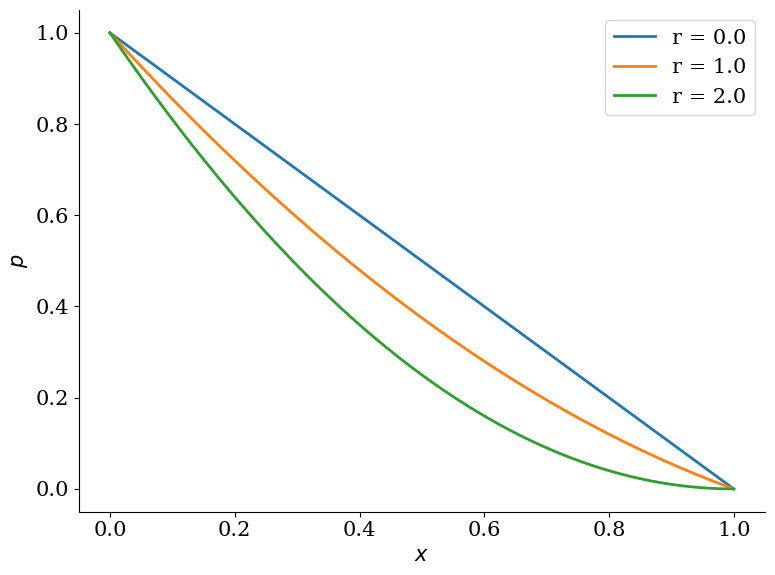

In [73]:
p_sol = lambda x,r: r/2 * x**2 - (1+r/2)*x + 1
coords = np.linspace(0,1,100)
fig, ax = plt.subplots()
for r in [0,1,2]:
    ax.plot(coords,p_sol(coords,r),label="r = %.1f" %r)
ax.set_xlabel('$x$')
ax.set_ylabel('$p$')
ax.legend()
fig.tight_layout();

In [84]:
v_sol = lambda x,r: -r*x + (1+r/2)
for r in [0,1,2]:
    print("r = %.1f. v left: %3f, v right: %3f" %(r,v_sol(0,r),v_sol(1,r)))

print("c left: 0, c right: 1")

r = 0.0. v left: 1.000000, v right: 1.000000
r = 1.0. v left: 1.500000, v right: 0.500000
r = 2.0. v left: 2.000000, v right: 0.000000
c left: 0, c right: 1


### Quellfrei

In [87]:
#generate elements of order 1 to 5 and calculate fluxes
r = 0
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.copy(ncoords)
    npress = p_sol(ncoords,r)
    f3, f4 = test_assembler_HC(elem,nconc,npress,r)
    print("element order: ", i)
    print("f_diff: ", f3)
    print("f_hyd: ", f4)
    print("f_adv = c * f_hyd: ", f4*nconc)
    print("---\n")

element order:  1
f_diff:  [ 1. -1.]
f_hyd:  [-1.  1.]
f_adv = c * f_hyd:  [-0.  1.]
---

element order:  2
f_diff:  [ 1.  0. -1.]
f_hyd:  [-1.  0.  1.]
f_adv = c * f_hyd:  [-0.  0.  1.]
---

element order:  3
f_diff:  [ 1.0000000e+00  8.8817842e-16 -8.8817842e-16 -1.0000000e+00]
f_hyd:  [-1.00000000e+00 -1.77635684e-15  8.88178420e-16  1.00000000e+00]
f_adv = c * f_hyd:  [-0.00000000e+00 -5.92118946e-16  5.92118946e-16  1.00000000e+00]
---



### Quelle $r=1$

In [88]:
#generate elements of order 1 to 5 and calculate fluxes
r = 1
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.copy(ncoords)
    npress = p_sol(ncoords,r)
    f3, f4 = test_assembler_HC(elem,nconc,npress,r)
    print("element order: ", i)
    print("f_diff: ", f3)
    print("f_hyd: ", f4)
    print("f_adv = c * f_hyd: ", f4*nconc)
    print("---\n")

element order:  1
f_diff:  [ 1. -1.]
f_hyd:  [-1.5  0.5]
f_adv = c * f_hyd:  [-0.   0.5]
---

element order:  2
f_diff:  [ 1.  0. -1.]
f_hyd:  [-1.50000000e+00  2.22044605e-16  5.00000000e-01]
f_adv = c * f_hyd:  [-0.00000000e+00  1.11022302e-16  5.00000000e-01]
---

element order:  3
f_diff:  [ 1.0000000e+00  8.8817842e-16 -8.8817842e-16 -1.0000000e+00]
f_hyd:  [-1.50000000e+00 -1.55431223e-15  1.44328993e-15  5.00000000e-01]
f_adv = c * f_hyd:  [-0.00000000e+00 -5.18104078e-16  9.62193288e-16  5.00000000e-01]
---



### Quelle r = 2

In [89]:
#generate elements of order 1 to 5 and calculate fluxes
r = 2
for i in range(1,4):
    nodes = np.linspace(0,i,i+1)
    ncoords = np.linspace(0,1,i+1)
    elem = line_element(i+1,ncoords,nodes)
    nconc = np.copy(ncoords)
    npress = p_sol(ncoords,r)
    f3, f4 = test_assembler_HC(elem,nconc,npress,r)
    print("element order: ", i)
    print("f_diff: ", f3)
    print("f_hyd: ", f4)
    print("f_adv = c * f_hyd: ", f4*nconc)
    print("---\n")

element order:  1
f_diff:  [ 1. -1.]
f_hyd:  [-2.  0.]
f_adv = c * f_hyd:  [-0.  0.]
---

element order:  2
f_diff:  [ 1.  0. -1.]
f_hyd:  [-2.00000000e+00  4.44089210e-16 -2.49800181e-16]
f_adv = c * f_hyd:  [-0.00000000e+00  2.22044605e-16 -2.49800181e-16]
---

element order:  3
f_diff:  [ 1.0000000e+00  8.8817842e-16 -8.8817842e-16 -1.0000000e+00]
f_hyd:  [-2.00000000e+00 -6.66133815e-16  5.55111512e-17  3.05311332e-16]
f_adv = c * f_hyd:  [-0.00000000e+00 -2.22044605e-16  3.70074342e-17  3.05311332e-16]
---



Die hydraulischen Knotenflüsse $\mathbf{R}_\text{H}$ entsprechen der analystischen Lösung. Die diffusiven Flüsse $\mathbf{R}_\text{Diff}$ ergeben sich korrekt aus $f_1$ (entsprechen Residuen von T in Implementierungen wie THM, TH, nicht aber HC). Die advektiven Flüsse ergeben sich jedoch entsprechend der erwarteten Lösung aus $\mathbf{R}_\text{Adv} = \mathbf{c} \odot \mathbf{R}_\text{H}$.